In [1]:
# %matplotlib
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

IMAGES_DIR = "../images"
OUTPUTS_DIR = "../outputs"

isBlack = lambda pix: (pix[0] == 0 and pix[1] == 0 and pix[2] == 0)

In [2]:
def floodfunc(img, x, y, visited, mask, iterations, max_iterations=40, th=10):
    isBlackG = lambda pix: (pix <= th)
    
    if iterations < max_iterations:
        
        visited[x][y] = 1
        mask[x][y] = 1

        if x+1 < img.shape[0] and not isBlackG(img[x+1][y]) and visited[x+1][y]==0:
            mask = floodfunc(img, x+1, y, visited, mask, iterations+1, max_iterations)

        if y+1 < img.shape[1] and not isBlackG(img[x][y+1]) and visited[x][y+1]==0:
            mask = floodfunc(img, x, y+1, visited, mask, iterations+1, max_iterations)

        if x-1 >= 0 and not isBlackG(img[x-1][y]) and visited[x-1][y]==0:
            mask = floodfunc(img, x-1, y, visited, mask, iterations+1, max_iterations)

        if y-1 >= 0 and not isBlackG(img[x][y-1]) and visited[x][y-1]==0:
            mask = floodfunc(img, x, y-1, visited, mask, iterations+1, max_iterations)
        
    return mask

In [13]:
def func(x,y,visited, m, img, iterations, max_iterations=40, th=10):
    isBlackG = lambda pix: (pix <= th)
    visited[x][y] = 1
    m.append((x,y))
    
    if iterations < max_iterations:
    
        if x+1< img.shape[0] and isBlackG(img[x+1][y]) and visited[x+1][y]==0:
            visited,m = func(x+1,y,visited, m, img, iterations+1, max_iterations)

        if y+1< img.shape[1] and isBlackG(img[x][y+1]) and visited[x][y+1]==0:
            visited,m = func(x,y+1, visited, m, img, iterations+1, max_iterations)

        if x-1>=0 and isBlackG(img[x-1][y]) and visited[x-1][y]==0:
            visited,m = func(x-1,y, visited, m, img, iterations+1, max_iterations)

        if y-1>=0 and isBlackG(img[x][y-1]) and visited[x][y-1]==0:
            visited,m = func(x,y-1, visited, m, img, iterations+1, max_iterations)

    return visited,m

In [14]:
validPt = lambda im, i, j: i>=0 and j>=0 and i<im.shape[0] and j<im.shape[1]

def markPts(im, x, y, th=2):
    out = np.copy(im)
    for i in range(x-th//2, x-th//2+th):
        for j in range(y-th//2, y-th//2+th):
            if validPt(im, i, j):
                out[i][j][0] = 255
                out[i][j][1] = 255
                out[i][j][2] = 255
    return out

In [41]:
def process(img_path, write_img=False, th=10):
    isBlackG = lambda pix: (pix <= th and th>=0)
    
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # to reduce noise in silhoutte pixels
    kernel = np.ones((5,5))
    img_gray = cv2.erode(img_gray, kernel, iterations=1)

    vector = []
    visited = np.zeros_like(img_gray)
    height   = img_gray.shape[0]
    width    = img_gray.shape[1]
    
    for i in range(img_gray.shape[0]):
        for j in range(img_gray.shape[1]):
            if isBlackG(img_gray[i][j]):
                m = []
                visited, v = func(i, j, visited, m, img_gray, 1, th=th)
                
                if len(v) >= 100:
                    vector.append(m)
                    
    img_cpy = np.copy(img_rgb)
    mask = np.zeros_like(img_gray)
    visited = np.zeros_like(img_gray)

    for i in vector:
        for j in i:
            mask = floodfunc(img_gray, j[0], j[1], visited, mask, 0, th=th)
    
    img_marked = np.copy(img)

    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i][j] == 1:
                for ch in range(3):
                    img_marked[i][j][ch] = min(img_marked[i][j][ch] + (ch+1)*30, 255)

    b_channel, g_channel, r_channel = cv2.split(img_marked)

    alpha_channel = np.zeros(b_channel.shape, dtype=b_channel.dtype)
    alpha_channel[mask==1] = 50
    alpha_channel[mask!=1] = 255

    img_cs = cv2.merge((b_channel, g_channel, r_channel, alpha_channel))
    img_cs_rgb = cv2.cvtColor(img_cs, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.imshow(img_rgb)
    plt.title("Silhouette Pixels")
    plt.subplot(122)
    plt.imshow(img_cs_rgb)
    plt.title("Context/Synthesis Masked Image")
    plt.show()
    
    if write_img:
        cv2.imwrite(os.path.join(OUTPUTS_DIR, img_path.split('/')[-1]), img_cs)

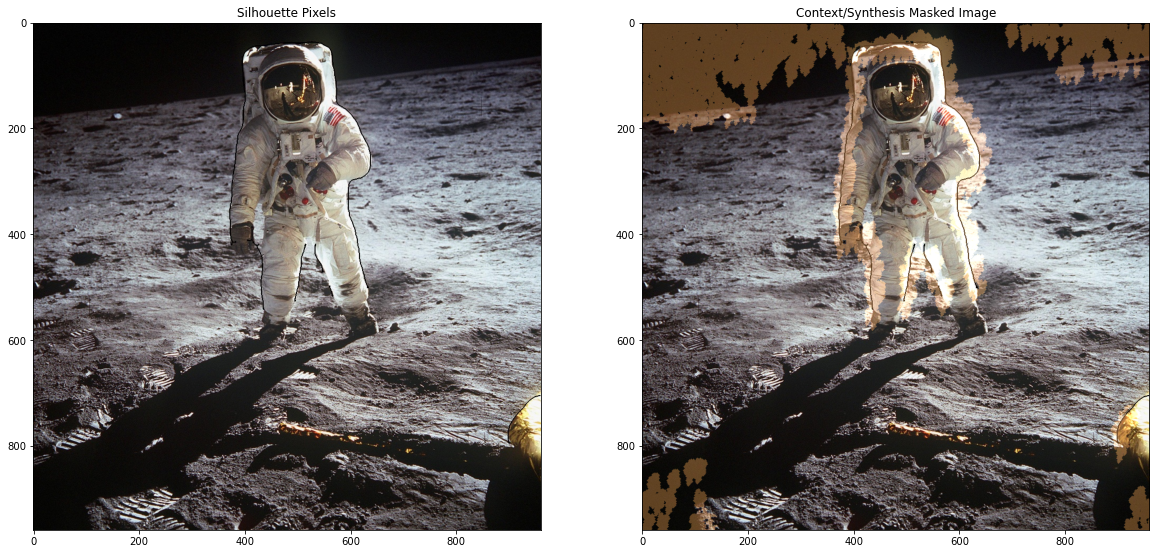

In [45]:
process(os.path.join(OUTPUTS_DIR, 'moon.jpg'), write_img=True, th=0)

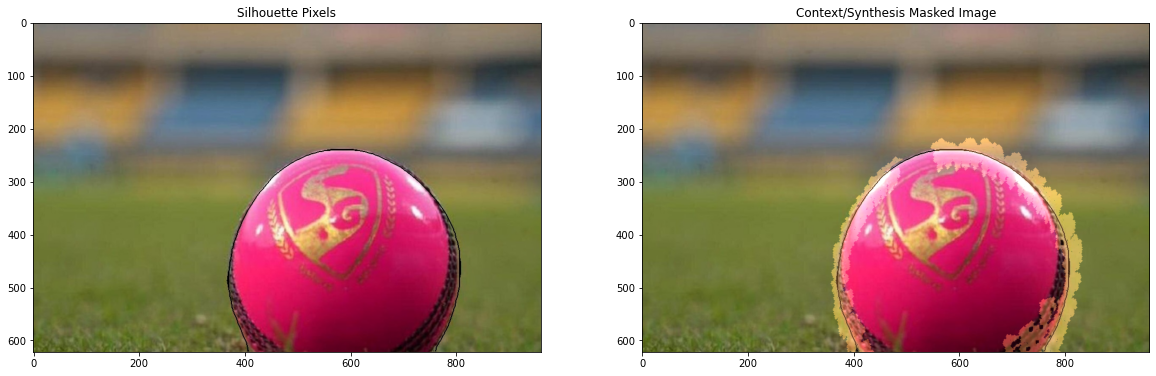

In [47]:
process(os.path.join(OUTPUTS_DIR, 'ball.jpg'), write_img=True)

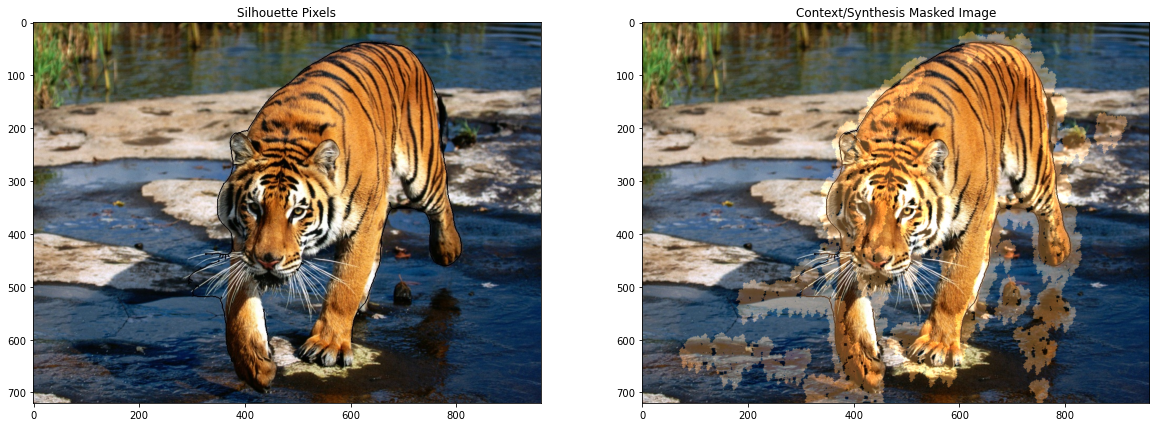

In [48]:
process(os.path.join(OUTPUTS_DIR, 'tiger.jpg'), write_img=True)